### Sonifications techniques used in the project:

1. Audification


2. Parameter-Mapping Sonififcation (PMson)


3. Wave Space Sonification (WSS)

#### Steps:
1. Use delay-embedding to transform the time series into a 2D space.
2. Implement the wave space function as described in the dissertation.
3. Move along the trajectory to generate the sound signal.
4. Use the pya library to compute the signal and sc3nb to sonify it.

In [1]:
#Libraries
import numpy as np
import time, os
import matplotlib.pyplot as plt
import sc3nb as scn
import pandas as pd
from pya import *
import scipy
%matplotlib widget
#%matplotlib inline

plt.rcParams['figure.figsize'] = (10,3)

In [3]:
sc = scn.startup()

<IPython.core.display.Javascript object>

Starting sclang process... [sclang | start reading ]
[sclang]  compiling class library...
[sclang]  	Found 855 primitives.
[sclang]  	Compiling directory '/Applications/SuperCollider.app/Contents/Resources/SCClassLibrary'
[sclang]  	Compiling directory '/Users/neina/Library/Application Support/SuperCollider/Extensions'
[sclang]  	numentries = 838063 / 12430290 = 0.067
[sclang]  	5505 method selectors, 2258 classes
[sclang]  	method table size 13367560 bytes, big table size 99442320
[sclang]  	Number of Symbols 12375
[sclang]  	Byte Code Size 378538
[sclang]  	compiled 328 files in 1.14 seconds
[sclang]  compile done
[sclang]  localhost : setting clientID to 0.
[sclang]  internal : setting clientID to 0.
[sclang]  Class tree inited in 0.01 seconds
[sclang]  
[sclang]  
[sclang]  *** Welcome to SuperCollider 3.13.0. *** For help type cmd-d.
Done.
Registering OSC /return callback in sclang... [sclang]  sc3> "sc3nb - Registering OSC /return callback".postln; r = r ? (); r.callback = { arg 

In [8]:
sc.server.blip()

In [6]:
# Reading the CSV file
dn = pd.read_csv("nino3all.csv", delimiter=",", 
                 names=["Year", "SST", "u1", "u2"], 
                 dtype={"Year": int, "SST": float})\
    .set_index("Year").loc[:,["SST"]]

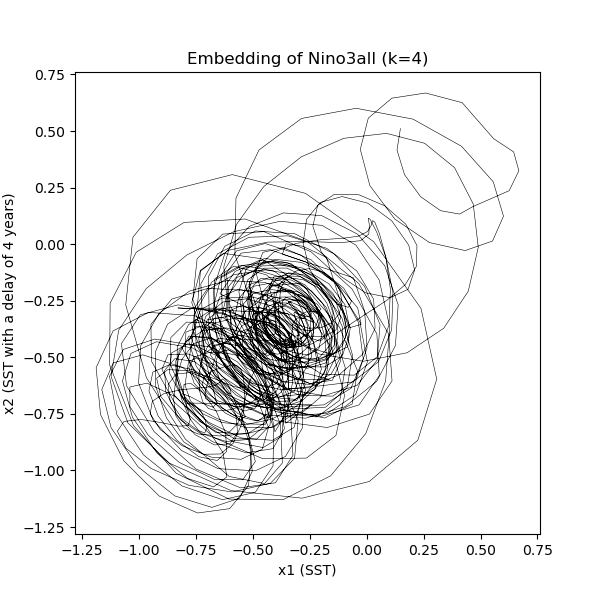

In [7]:
#TDE
k = 4

# Creating the 2D embedding using delay
dn['x1'] = dn['SST']
dn['x2'] = dn['SST'].shift(-k)

# Dropping NaN values that may result from the shift
dn.dropna(inplace=True)

# Plotting the 2D embedding
plt.figure(figsize=(6,6))
plt.plot(dn['x1'], dn['x2'], 'k-', lw=0.4)
plt.xlabel('x1 (SST)')
plt.ylabel('x2 (SST with a delay of 4 years)')
plt.title('Embedding of Nino3all (k=4)')
plt.show()

The 2D embedding of the time series visualises the trajectory in the embedded space. Now, we move on to the next step, where we define the wave space function as described in the Canonical Wave Space Sonification method.

In [9]:
# Importing the required library for interpolation
from scipy.interpolate import interp1d
import numpy as np

# Defining the interpolation functions for x1 and x2
ts = dn.index.values # Year numbers
fx1_fn = interp1d(ts, dn['x1'].values, kind='linear')
fx2_fn = interp1d(ts, dn['x2'].values, kind='linear')

# Testing the interpolation functions at a specific time (e.g., t=1983.01253)
t_test = 1983.01253
fx1_val = fx1_fn(t_test)
fx2_val = fx2_fn(t_test)

fx1_val, fx2_val

(array(0.43067957), array(-0.0276236))

In [10]:
# Importing Asig from pya for audio signal creation
from pya import Asig

# Checking the valid range of years in our data
min_year, max_year = ts.min(), ts.max()
min_year, max_year

# Defining the time samples for 10 seconds at a sampling rate of 44100
ts_audio = np.linspace(min_year, max_year, 44100 * 15)

# Interpolating the x1 and x2 coordinates
x1_s = fx1_fn(ts_audio)
x2_s = fx2_fn(ts_audio)

# Defining a function V(x1,x2) for wave space with chosen frequency constants
freq1 = 440 # Frequency for x1
freq2 = 880 # Frequency for x2

def V(x1, x2):
    return np.sin(2 * np.pi * freq1 * x1) + np.sin(2 * np.pi * freq2 * x2)

# Creating an empty asig for 10 seconds
an = Asig(1500, sr=1000) #1498 #sr=44100

# Looping through all entries and computing the wave space audio data
for i in range(len(an.sig)):
    an.sig[i] = V(x1_s[i], x2_s[i])

Asig(''): 1 x 1500 @ 1000Hz = 1.500s cn=['0']

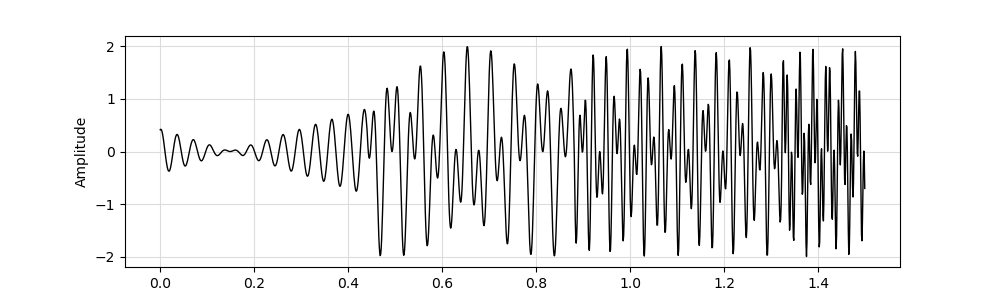

In [15]:
plt.figure();
plt.grid(color = 'gainsboro')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
an.plot(color="k", lw=1)

#an.stereo().play(rate=1.5); #norm(0.5) play(rate=1.5)

In [20]:
#We use PMSon D to sonify the CWSS computed signal
def pmson_D(asig, rate=1, decim=1, p0=50):
    # instantiate synths
    syn = scn.Synth("s2", {"freq": 300, "pan": 0, "amp": 0.2}) 
    # update synths
    for i, v in enumerate(asig[::decim].sig):
        syn.num = scn.linlin(v, -2, 2, 1, 10)
        syn.freq = scn.midicps(p0 + scn.linlin(v, -2, 2, -10, 30))
        syn.amp = scn.dbamp(scn.linlin(v, -2, 2, -30, -10))
        syn.pan = 0
        time.sleep(1 / asig.sr * decim / rate)  
    syn.free() 

In [24]:
#Play the sonification at rate = 0.1
pmson_D(an, rate=0.1, decim=1) # all data in 14 secs

In [25]:
#Play the sonification at rate = 0.05
pmson_D(an, rate=0.05) # a bit slower (28 seconds)

In [23]:
sc.server.free_all()

[sclang]  sc3> r['callback'].value("\"sc3nb - Creating SynthDef sc3nb_volumeAmpControl2\".postln; r.tmpSynthDef = SynthDef(\"sc3nb_volumeAmpControl2\", { | volumeAmp = 1, volumeLag = 0.1, gate=1, bus | XOut.ar(bus, Linen.kr(gate, releaseTime: 0.05, doneAction:2), In.ar(bus, 2) * Lag.kr(volumeAmp, volumeLag) ); }); SynthDescLib.global.add(r.tmpSynthDef.asSynthDesc); r.tmpSynthDef.asBytes();", "127.0.0.1", 57133);
[sclang]  sc3nb - Creating SynthDef sc3nb_volumeAmpControl2
[sclang]  -> Int8Array[ 83, 67, 103, 102, 0, 0, 0, 2, 0, 1, 23, 115, 99, 51, 110, 98, 95, 118, 111, 108, 117, 109, 101, 65, 109, 112, 67, 111, 110, 116, 114, 111, 108, 50, 0, 0, 0, 4, 60, 35, -41, 10, 63, -128, 0, 0, 61, 76, -52, -51, 64, 0, 0, 0, 0, 0, 0, 4, 63, -128, 0, 0, 61, -52, -52, -51, 63, -128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 9, 118, 111, 108, 117, 109, 101, 65, 109, 112, 0, 0, 0, 0, 9, 118, 111, 108, 117, 109, 101, 76, 97, 103, 0, 0, 0, 1, 4, 103, 97, 116, 101, 0, 0, 0, 2, 3, 98, 117, 115, 0, 0, 0, 3, 0, 0, 0, 

**1-to-many sonification** (Code by Dr. Hermann)
* for instance map the data value to pitch so that p-wave and t-wave stand out
* additionally map the data to brightness so that the r-peak is understood
* play with additional mappings, e.g. change of value to amplitude...

In [27]:
queue = scn.TimedQueueSC()

In [28]:
x = scn.Synth("s2", {"amp": 0.01, "freq": 200})

t0 = time.time()
for i, r in enumerate(an.sig):
    onset = t0 + i * 0.01 + 1

    amp = abs(r)
    num = 1
    if r > -0.5: num = 2
    if r >  0: num = 3
    freq = scn.linlin(r, -1, 1, 200, 400)
    bundler = scn.Bundler(onset, "/n_set", [x.nodeid, "amp", amp, "freq", freq, "num", num])
    queue.put_bundler(onset-2, bundler)
queue.put(onset + 0.1, x.free)
# queue.put_msg(onset+0.1, "/n_free", [x.nodeid])

In [29]:
sc.server.free_all()

[sclang]  sc3> r['callback'].value("\"sc3nb - Creating SynthDef sc3nb_volumeAmpControl2\".postln; r.tmpSynthDef = SynthDef(\"sc3nb_volumeAmpControl2\", { | volumeAmp = 1, volumeLag = 0.1, gate=1, bus | XOut.ar(bus, Linen.kr(gate, releaseTime: 0.05, doneAction:2), In.ar(bus, 2) * Lag.kr(volumeAmp, volumeLag) ); }); SynthDescLib.global.add(r.tmpSynthDef.asSynthDesc); r.tmpSynthDef.asBytes();", "127.0.0.1", 57133);
[sclang]  sc3nb - Creating SynthDef sc3nb_volumeAmpControl2
[sclang]  -> Int8Array[ 83, 67, 103, 102, 0, 0, 0, 2, 0, 1, 23, 115, 99, 51, 110, 98, 95, 118, 111, 108, 117, 109, 101, 65, 109, 112, 67, 111, 110, 116, 114, 111, 108, 50, 0, 0, 0, 4, 60, 35, -41, 10, 63, -128, 0, 0, 61, 76, -52, -51, 64, 0, 0, 0, 0, 0, 0, 4, 63, -128, 0, 0, 61, -52, -52, -51, 63, -128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 9, 118, 111, 108, 117, 109, 101, 65, 109, 112, 0, 0, 0, 0, 9, 118, 111, 108, 117, 109, 101, 76, 97, 103, 0, 0, 0, 1, 4, 103, 97, 116, 101, 0, 0, 0, 2, 3, 98, 117, 115, 0, 0, 0, 3, 0, 0, 0, 

In [ ]:
x = scn.Synth("s2", {"amp": 0.01, "freq": 200})

t0 = time.time()
for i, r in enumerate(an.sig):
    onset = t0 + i * 0.01 + 1
    amp = 0.2 * abs(r) # just an example, do whatever you want / need
    freq = scn.linlin(r, -1, 1, 200, 1000)
    bundler = scn.Bundler(onset, "/n_set", [x.nodeid, "amp", amp, "freq", freq])
    queue.put_bundler(onset-0.2, bundler)
queue.put(onset + 0.1, x.free)   # queue.put_msg(onset+0.1, "/n_free", [x.nodeid])

In [ ]:
queue.close()

In [ ]:
#Use to close the server
#sc.exit()